# Anomaly Detection

### 1. Loading the Data
- using matlab file
- X : training set
- Xval, yval : cross-validation set

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [3]:
mat = loadmat("ex8data1.mat")

In [5]:
X = mat["X"]
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Dec  1 15:37:10 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[13.04681517, 14.74115241],
        [13.40852019, 13.7632696 ],
        [14.19591481, 15.85318113],
        [14.91470077, 16.17425987],
        [13.57669961, 14.04284944],
        [13.92240251, 13.40646894],
        [12.82213164, 14.22318782],
        [15.67636615, 15.89169137],
        [16.16287532, 16.20299807],
        [12.66645095, 14.89908374],
        [13.98454962, 12.95800822],
        [14.06146043, 14.54908874],
        [13.38988671, 15.56202142],
        [13.39350475, 15.62698794],
        [13.97900926, 13.28061494],
        [14.16791259, 14.46583829],
        [13.96176145, 14.75182421],
        [14.45899735, 15.07018563],
        [14.58476372, 15.82743424],
        [12.07427074, 13.0671109 ],
        [13.5491294 , 15.53827677],
        [13.98625042, 14.78776304],
        [14.96991942, 16.51830493],
        [14.25576597, 15.294

In [4]:
Xval = mat["Xval"]
np.shape(Xval)

(307, 2)

In [5]:
yval = mat["yval"]
np.shape(yval)

(307, 1)

Text(0, 0.5, 'Throughput (mb/s)')

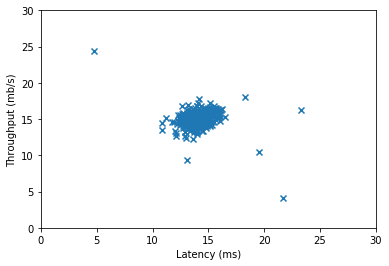

In [6]:
plt.scatter(X[:,0],X[:,1],marker="x")
plt.xlim(0,30)
plt.ylim(0,30)
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mb/s)")

### 2.Gaussian Distribution
- make function
- compute mean, variance
- X.shape[0] = 307 : num of data
![title](gaussian.png)

- input : data array
- return : 각 feature에 대한 평균, 분산

In [7]:
def forGaussian(X):
    m = X.shape[0]
    
    sum_ = np.sum(X,axis=0)
    mu = 1/m * sum_
    
    var = 1/m * np.sum((X-mu)**2,axis=0)
    
    return mu, var



- use 'forGaussian' function, compute each mean, variance of X(training set) features  

In [8]:
mu, sigma2 = forGaussian(X)
mu, sigma2

(array([14.11222578, 14.99771051]), array([1.83263141, 1.70974533]))

### 3. Multivariate Gaussian Distribution
- make function
- compute probability
- diag() : diagonal matrix
- linalg.det() : matrix determinant
- linalg.pinv() : Compute the (Moore-Penrose) pseudo-inverse of a matrix
![title](multivariate.png)

- input : data array, 평균, 분산(위의 forGaussian 함수에서 구함)
- return probability

In [9]:
def multivariate(X, mu, sigma2):
    k = len() #mu num of features
    
    sigma2 = np.diag(sigma2) #대각행렬(diagonal matrix), 2x2
    X = X - mu.T # X는 307x2, mu는 1x2
    
    # sigma2에 대한 행렬식, 유사역행렬(예외처리 없이 진행가능하게끔)
    # X@np.linalg.pinv(sigma2) : (307x2)x(2x2) = 307x2
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(sigma2)**0.5)) * np.exp(-0.5*np.sum(X@np.linalg.pinv(sigma2)*X,axis=1))
    return p

- using 'multivariate' function, compute posibility of X(training set)
- check from index 0 to index 4

In [1]:
p = multivariate(X,mu,sigma2)
p[:5]

NameError: name 'multivariate' is not defined

### 4. Visualize the fit
- draw contour

- linspace(start, end, num)
- meshgrid : process making grid point
- flatten : multi-dimensional array -> one-dimensional array
- hstack : Associate two or more arrays with the same number of rows

Text(0, 0.5, 'Throughput (mb/s)')

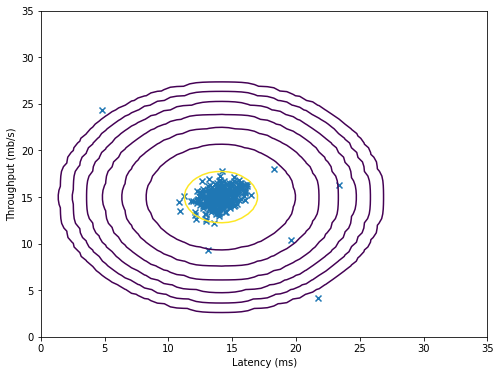

In [11]:
plt.figure(figsize=(8,6))
plt.scatter(X[:,0], X[:,1], marker="x")

X1, X2 = np.meshgrid(np.linspace(0,35,num=70), np.linspace(0,35,num=70))
p2 = multivariate(np.hstack((X1.flatten()[:,np.newaxis],X2.flatten()[:,np.newaxis])),mu,sigma2)

contour_level = 10**np.array([np.arange(-20,0,3,dtype=np.float)])
plt.contour(X1, X2, p2[:,np.newaxis].reshape(X1.shape), levels=contour_level[0])

plt.xlim(0,35)
plt.ylim(0,35)
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mb/s)")

### 5. Select the threshold
- make function
- compute epsilon, F1
![title](f1Score.png)

1. compute fraction of true positives/false positives/false negatives/true negatives
2. compute precision/recall
3. compute F1-score
4. pick the value of epsilon which maximizes the score on CV set

- precision : Positive Predictive Value(The proportion of what the model classifies as True to be true)
- recall : Percentage of actual true that the model predicts true
- F1-score : instead of accuracy, if recall is low, F1-score close to zero
![title](confusion_matrix.png)

In [12]:
def selectThreshold(yval, pval) :
    best_epi = 0
    best_F1 = 0
    
    stepsize = (max(pval)-min(pval))/1000
    epi_range = np.arange(pval.min(),pval.max(),stepsize)
    
    for epi in epi_range :
        predictions = (pval<epi)[:,np.newaxis]
        tp = np.sum(predictions[yval==1]==1)
        fp = np.sum(predictions[yval==0]==1)
        fn = np.sum(predictions[yval==1]==0)
        
        prec = tp/(tp+fp) # 정밀도 : 
        rec = tp/(tp+fn) # 재현율 : 
        
        F1 = (2*prec*rec)/(prec+rec)
        
        if F1 > best_F1 :
            best_F1 = F1
            best_epi = epi
            
    return best_epi, best_F1

In [13]:
pval = multivariate(Xval, mu, sigma2)
epsilon, F1 = selectThreshold(yval, pval)

print("Best epsilon found using cross-validation:",epsilon)
print("Best F1 on Cross Validation Set:",F1)

Best epsilon found using cross-validation: 8.990852779269495e-05
Best F1 on Cross Validation Set: 0.8750000000000001


C:\Users\Moon\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  


### 6. Visualize the anomalies
- find anomalies using epsilon
- draw contour with another solution (using transpose)

- p < epsilon : anomalous, p >= epsilon : non-anomalous
- y=0 : non-anomalous, y=1 : anomalous

- outliers is an array of anomalous

In [25]:
outliers = np.nonzero(p<epsilon)[0] # p<epsilon : false, true array를 만들어줌(false=0, true=1)
outliers

array([300, 301, 303, 304, 305, 306], dtype=int64)

In [26]:
(p<epsilon)[:5]

array([False, False, False, False, False])

Text(0, 0.5, 'Throughput (mb/s)')

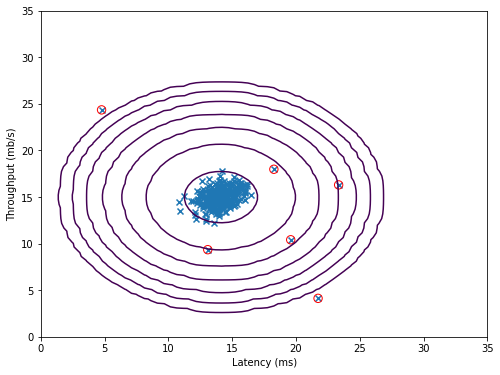

In [50]:
plt.figure(figsize=(8,6))

plt.scatter(X[:,0],X[:,1],marker="x")

X1,X2 = np.meshgrid(np.linspace(0,35,num=70),np.linspace(0,35,num=70))
p2 = multivariate(np.hstack((X1.flatten()[:,np.newaxis],X2.flatten()[:,np.newaxis])), mu, sigma2)

plt.scatter(X[outliers,0],X[outliers,1],marker ="o",facecolor="none",edgecolor="r",s=70)

#plt.contour(X1, X2, p2[:,np.newaxis].reshape(X1.shape), levels=contour_level[0])

trans = contour_level.T
for i in range(0,7) :
    plt.contour(X1,X2,p2[:,np.newaxis].reshape(X1.shape), trans[i])

plt.xlim(0,35)
plt.ylim(0,35)
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mb/s)")

# High Dimensional Dataset
- use second dataset

### 1. Loading the data

In [51]:
mat2 = loadmat("ex8data2.mat")
X2 = mat2["X"]
np.shape(X2)

(1000, 11)

In [52]:
Xval2 = mat2["Xval"]
np.shape(Xval2)

(100, 11)

In [53]:
yval2 = mat2["yval"]
np.shape(yval2)

(100, 1)

In [54]:
mu2, sigma2_2 = forGaussian(X2)

- training set

In [55]:
p3 = multivariate(X2, mu2, sigma2_2)

- cross-validation set

In [56]:
pval2 = multivariate(Xval2, mu2, sigma2_2)

- find the best threshold

In [57]:
epsilon2, F1_2 = selectThreshold(yval2, pval2)
print("Best epsilon found using cross-validation:",epsilon2)
print("Best F1 on Cross Validation Set:",F1_2)
print("# Outliers found:",np.sum(p3<epsilon2))

Best epsilon found using cross-validation: 1.3772288907613575e-18
Best F1 on Cross Validation Set: 0.6153846153846154
# Outliers found: 117


C:\Users\Moon\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  
